In [10]:
import torch
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [11]:
block_size = 3
B  = 26
NE = 2
NH = 100
BATCH_SIZE = 32
NUM_ITERATIONS=10000
learning_rate = 0.1

random.seed(0)

In [12]:
def getnum(x): return (ord(x) - ord('a')) if x.isalpha() else B

def build_dataset(words):

    X, Y = list(), list()
    for w in words:
        if len(w) < block_size: continue
        w = "." * block_size + w + '.'
        for p in range(block_size, len(w)):
            prev = w[(p - block_size) : p]
            next = w[p]
            prev = [getnum(x) for x in prev]
            next = getnum(next)
            X.append(prev)
            Y.append(next)
    return torch.tensor(X), torch.tensor(Y)

In [13]:
with open("input.txt", "r") as f: words = f.read().splitlines()
random.shuffle(words)

n1 = int(0.01 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xvd, Yvd = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr.shape, Ytr.shape)
print(Xvd.shape, Yvd.shape)
print(Xte.shape, Yte.shape)

torch.Size([2261, 3]) torch.Size([2261])
torch.Size([202996, 3]) torch.Size([202996])
torch.Size([22694, 3]) torch.Size([22694])


In [14]:
g = torch.Generator().manual_seed(0)
C = torch.randn((B + 1, NE), generator=g)
Wh = torch.randn((block_size * NE, NH), generator=g)
bh = torch.randn(NH, generator=g)
Wt = torch.randn((NH, B + 1), generator=g)
bt = torch.randn((B + 1), generator=g)

all_params =[C, Wh, bh, Wt, bt]
for param in all_params:
    param.requires_grad = True


num_params = sum([param.nelement() for param in all_params])
print(num_params)


3481


In [15]:
losses = [0] * NUM_ITERATIONS

for iter in range(NUM_ITERATIONS):
    indices = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    embeddings = C[Xtr[indices]]
    #print(embeddings.shape)
    hidden = torch.tanh(embeddings.view(-1, block_size * NE) @ Wh + bh)
    logits = hidden @ Wt + bt
    loss = F.cross_entropy(logits, Ytr[indices])

    for param in all_params: param.grad = None
    loss.backward()
    learning_rate /= (1.0 if iter < NUM_ITERATIONS / 2 else 10)
    for param in all_params: param.data -= learning_rate * param.grad

    losses[iter] = loss.log10().item()

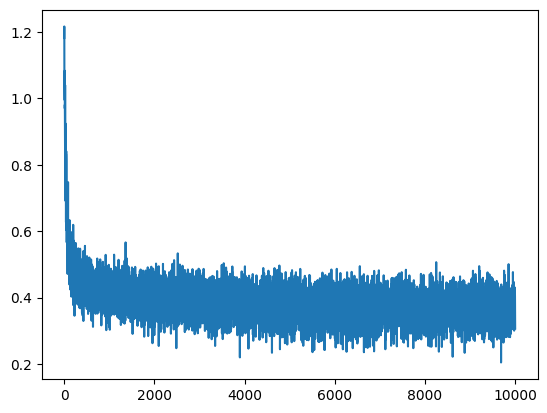

In [16]:
plt.plot(range(len(losses)), losses)